# Chinook Music Database - Analysis

This project uses SQL to answer hypothetical buisness questions. We will be working with a version of a database called Chinook, which contains information about a fictional digital music shop (i.e. an iTunes-like store). 

The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables. 

NOTE: This analysis was completed as part of the SQL courses on the Dataquest e-learning platform.

## Library Import and Creation of Helper Functions

We will begin by importing the various libraries that will be used throughout the anlaysis, and by creating a few helper functions for running our SQL queries.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Our first function uses a context manager to handle the connection to the database, and returns a dataframe as the output. 

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

The next function is one that can be used for SQL queries that don't return tables (such as "CREATE VIEW").

In [3]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

Finally, we'll create a function that uses our run_query() function to return a list of all tables and views in our databases.

In [4]:
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Top-Selling Genres in the United States

Our Chinook store has signed a deal with a new record label, and will initially be adding three of their albums to the store. The label specializes in artists from the US, so we've been tasked with finding out which genres sell best in the US so that we can determine which genres the three albums should represent.

In order to do this we will write a query that returns each genre, the number of tracks sold in that genre, and the percentage of all tracks sold that this number represents.

In [5]:
top_us_genres = '''
WITH us_tracks_sold AS
    (
    SELECT il.*
    FROM invoice_line il
    JOIN invoice i ON il.invoice_id = i.invoice_id
    JOIN customer c ON i.customer_id = c.customer_id
    WHERE c.country = "USA"
    )

SELECT 
    g.name genre, 
    COUNT(uts.invoice_line_id) tracks_sold,
    (CAST(COUNT(uts.invoice_line_id) AS FLOAT) / (SELECT COUNT(*) FROM us_tracks_sold)) * 100 tracks_sold_pct
FROM us_tracks_sold uts
JOIN track t ON uts.track_id = t.track_id
JOIN genre g ON t.genre_id = g.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''
run_query(top_us_genres)

,genre,tracks_sold,tracks_sold_pct
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


From this list, we can clearly see that the top three genres in the US (by number of tracks sold) are: Rock, Alternative & Punk, and Metal.  Therefore, the albums that we include in the Chinook store should come from these genres in order to maximize sales.

This information will be included in a presentation to company executives, so we will plot this in a bar graph that can be included in the presentation.

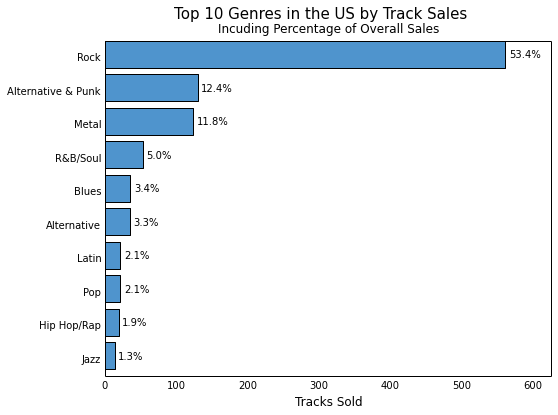

In [6]:
us_genre_sales = run_query(top_us_genres)

labels = us_genre_sales['genre']
x = range(len(labels))
y = us_genre_sales['tracks_sold']

plt.figure(figsize=(8, 6))
ax = plt.subplot()
plt.barh(x, y, color='#4f94cd')
plt.gca().invert_yaxis() #inverting the y axis so that results appear in descending order

ax.set_yticks(range(len(labels)))
ax.set_yticks([float(n)+0.5 for n in ax.get_yticks()]) #positions the yticks in the center of the bars
ax.set_yticklabels(labels)
ax.tick_params(bottom="off", left="off", top="off", right="off")
ax.set_xlim(0, 625)

plt.xlabel('Tracks Sold', fontdict = {'fontsize' : 12})
plt.suptitle('Top 10 Genres in the US by Track Sales', fontdict = {'fontsize' : 15})
plt.title('Incuding Percentage of Overall Sales', fontdict = {'fontsize' : 12})
ax.title.set_position([.5, 1.01]) #adding space between the title and the plot

#Below we'll label the bars with the percentage of overall sales for each genre.
for i, v in zip(ax.patches, us_genre_sales['tracks_sold_pct'].tolist()):
    ax.text(i.get_width()+6, i.get_y()+.5, str(round(v, 1)) + '%');

## Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing better or worse than the others.

To do so, we will write a query that finds the total dollar amount of sales assigned to each sales support agent within the company. We will also look at the employees' start dates, as that may have an impact on their total sales. 

In [7]:
employee_sales = '''
SELECT
    e.first_name || " " || e.last_name employee, 
    e.hire_date, 
    SUM(i.total) total_sales
FROM employee e
JOIN customer c ON e.employee_id = c.support_rep_id
JOIN invoice i ON c.customer_id = i.customer_id
WHERE e.title = "Sales Support Agent"
GROUP BY 1
'''
run_query(employee_sales)

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


From this, we can easily see that Jane Peacock has the highest total sales amount, but she has also worked at the company for the longest amount of time.  When considering the total sales and start dates of the other two employees, it looks like everyone is relatively similar in their sales performance. 

We will also plot this data in a bar graph that could be included in a presentation.

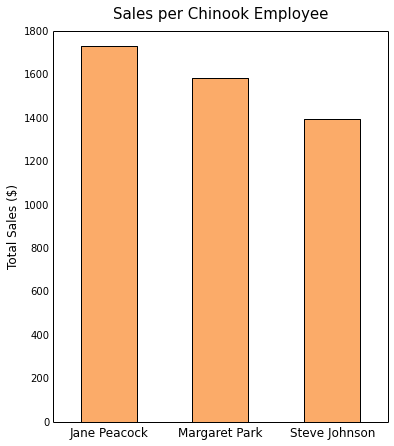

In [8]:
employee_sales_data = run_query(employee_sales)

names = employee_sales_data['employee']
x = range(len(names))
y = employee_sales_data['total_sales']

fig, ax = plt.subplots(figsize=(6, 7))
plt.bar(x, y, width=0.5, align='center', color='#fbab69')

ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, fontsize=12)
ax.tick_params(bottom="off", left="off", top="off", right="off")

plt.ylabel('Total Sales ($)', fontdict = {'fontsize' : 12})
plt.title('Sales per Chinook Employee', fontdict = {'fontsize' : 15})
ax.title.set_position([.5, 1.02]);

## Sales by Country

Our next task is to analyze the customer sales data by countryto see if there are any actionable trends. More specifically, we will be calculating the following data points for each country represented in the Chinook database:

* total number of customers
* total value of sales
* average value of sales per customer
* average order value

Because there are a number of countries with only one customer, we will group these countries as "Other" in our analysis. 

In [9]:
sales_by_country = '''
WITH country_or_other AS
    (
    SELECT
        CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                 ) = 1 THEN "Other"
           ELSE c.country
        END AS country,
        c.customer_id, 
        il.*
    FROM invoice_line il
    JOIN invoice i ON il.invoice_id = i.invoice_id
    JOIN customer c ON i.customer_id = c.customer_id
    )

SELECT
    country,
    COUNT(DISTINCT customer_id) total_customers,
    SUM(unit_price) total_sales,
    SUM(unit_price) / COUNT(distinct customer_id) sales_per_customer,
    SUM(unit_price) / COUNT(distinct invoice_id) average_order
FROM country_or_other
GROUP BY 1
ORDER BY 2 DESC, 3 DESC
'''
run_query(sales_by_country)

,country,total_customers,total_sales,sales_per_customer,average_order
0,Other,15,1094.94,72.996000,7.448571
1,USA,13,1040.49,80.037692,7.942672
2,Canada,8,535.59,66.948750,7.047237
3,Brazil,5,427.68,85.536000,7.011148
4,France,5,389.07,77.814000,7.781400
5,Germany,4,334.62,83.655000,8.161463
6,United Kingdom,3,245.52,81.840000,8.768571
7,Czech Republic,2,273.24,136.620000,9.108000
8,Portugal,2,185.13,92.565000,6.383793
9,India,2,183.15,91.575000,8.721429


This looks good, but it would be better to have the "Other" values at the bottom of our list.  To do that, we will add a "sorting" column to our query, make the whole thing a sorted subquery, then run a final query that omits the sorting column.

In [10]:
sorted_sales_by_country = '''
WITH country_or_other AS
    (
    SELECT
        CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                 ) = 1 THEN "Other"
           ELSE c.country
        END AS country,
        c.customer_id, 
        il.*
    FROM invoice_line il
    JOIN invoice i ON il.invoice_id = i.invoice_id
    JOIN customer c ON i.customer_id = c.customer_id
    )

SELECT
    country, 
    total_customers, 
    total_sales, 
    sales_per_customer, 
    average_order
FROM
    (
    SELECT
        country,
        COUNT(distinct customer_id) total_customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / COUNT(distinct customer_id) sales_per_customer,
        SUM(unit_price) / COUNT(distinct invoice_id) average_order, 
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY 1
    ORDER BY sort ASC, total_sales DESC
    )
'''
run_query(sorted_sales_by_country)

,country,total_customers,total_sales,sales_per_customer,average_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


Now we will create a couple plots to help us further explore the data.

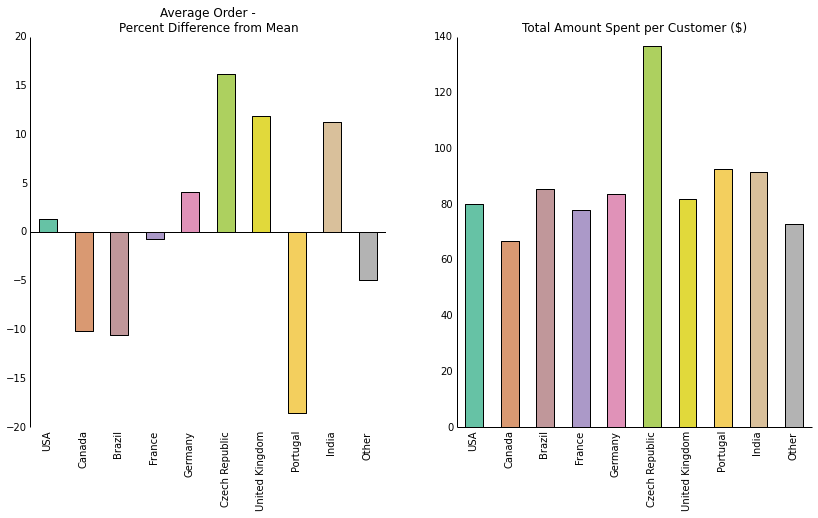

In [11]:
country_data = run_query(sorted_sales_by_country)
countries = country_data['country'] #for labeling
colors = [plt.cm.Set2(i) for i in np.linspace(0, 1, country_data.shape[0])] #assigns a different color to each country

fig = plt.figure(figsize=(14,7))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

#First Plot
average_order = country_data['average_order'].copy()
pct_diff_from_mean = average_order * 100 / average_order.mean() -  100
pct_diff_from_mean.plot.bar(
    ax=ax1,
    color=colors,
    title="Average Order - \nPercent Difference from Mean"
)

ax1.set_xticks(range(len(countries)))
ax1.set_xticklabels(countries)
ax1.tick_params(top="off", right="off", left="off", bottom="off")
ax1.axhline(0, color='k')
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["bottom"].set_visible(False)

#Second Plot
sales_per_customer = country_data['sales_per_customer'].copy()
sales_per_customer.plot.bar(
    ax=ax2,
    color=colors,
    title="Total Amount Spent per Customer ($)"
)

ax2.set_xticks(range(len(countries)))
ax2.set_xticklabels(countries)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

From this, it appears as though customers from the Czech Republic are the biggest spenders, both on average and overall.  However, it is very important to note that the data from that country only represents two customers, who may be outliers for the country overall.  Therefore, this data should be used with caution.  There is more data available for customers from the United States, Canada, and Brazil, so that information may be more actionable.  From looking at the graphs for those countries, it appears as though efforts could be made to increase the average sale amounts for both Canada and Brazil.

## Are Customers Buying Tracks, or Full Albums?

The Chinook store is set up in a way that allows customers to purchase either an entire album, or a collection of one or more individual tracks. The store does not let customers purchase a whole album, and then add individual tracks to that same purchase.

Management is currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs entire albums, so that management can use this data to understand the effect this decision might have on overall revenue. 

In order to answer this question, we will have to identify how many invoices contain all the tracks from an album.  We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks. 

In [12]:
albums_or_tracks = '''
WITH invoice_track_one AS
    (
    SELECT 
        il.invoice_id invoice_id, 
        MIN(track_id) first_track
    FROM invoice_line il
    GROUP BY 1
    )
  
SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(COUNT(invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice) percent_of_invoices
FROM
    (SELECT 
        ito.*,
        CASE
            WHEN
                (SELECT t.track_id FROM track t
                WHERE t.album_id = (SELECT t2.album_id from track t2
                                    WHERE t2.track_id = ito.first_track)
    
                EXCEPT
    
                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = ito.invoice_id) IS NULL
    
            AND
                (SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = ito.invoice_id
            
                EXCEPT
            
                SELECT t.track_id FROM track t
                WHERE t.album_id = (SELECT t2.album_id from track t2
                                    WHERE t2.track_id = ito.first_track)) IS NULL
            THEN 'Yes'
            ELSE 'No'
        END AS "album_purchase"
    FROM invoice_track_one ito)
GROUP BY album_purchase;
'''
run_query(albums_or_tracks)

,album_purchase,number_of_invoices,percent_of_invoices
0,No,500,0.814332
1,Yes,114,0.185668


In the above query, we started by identifying one track from an invoice (we randomly chose to use the first track). Then, whithin the CASE statement, we did the following:
* Pulled a list of all the tracks from the album id that matches the album id for our first track on the invoice.
* We then pulled a list of all the tracks from the invoice id that matches the invoice id from our first track.
* Using an except statement, we compare the two lists. If the result is null, the lists match.
* After the AND, we simply switch our comparison, and pull a list of invoice tracks, except for the tracks from the ablum.
* If both of these EXCEPT comparisons are null, the purchase was an album purchase, and is identified as such.

From the resulting table, we can see that album purchases account for almost one fifth of total sales, so we would advise against ceasing album sales.

NOTE: This concludes the portion of the analysis that was completed for the SQL e-learning course.

## Next Steps

Future updates to this project will explore answers to the following questions:
* Which artist appears in the most playlists?
* How many tracks have been purchased vs not purchased?
* Is the range of tracks in the store reflective of their sales popularity?
* Do protected vs non-protected media types have an effect on popularity?